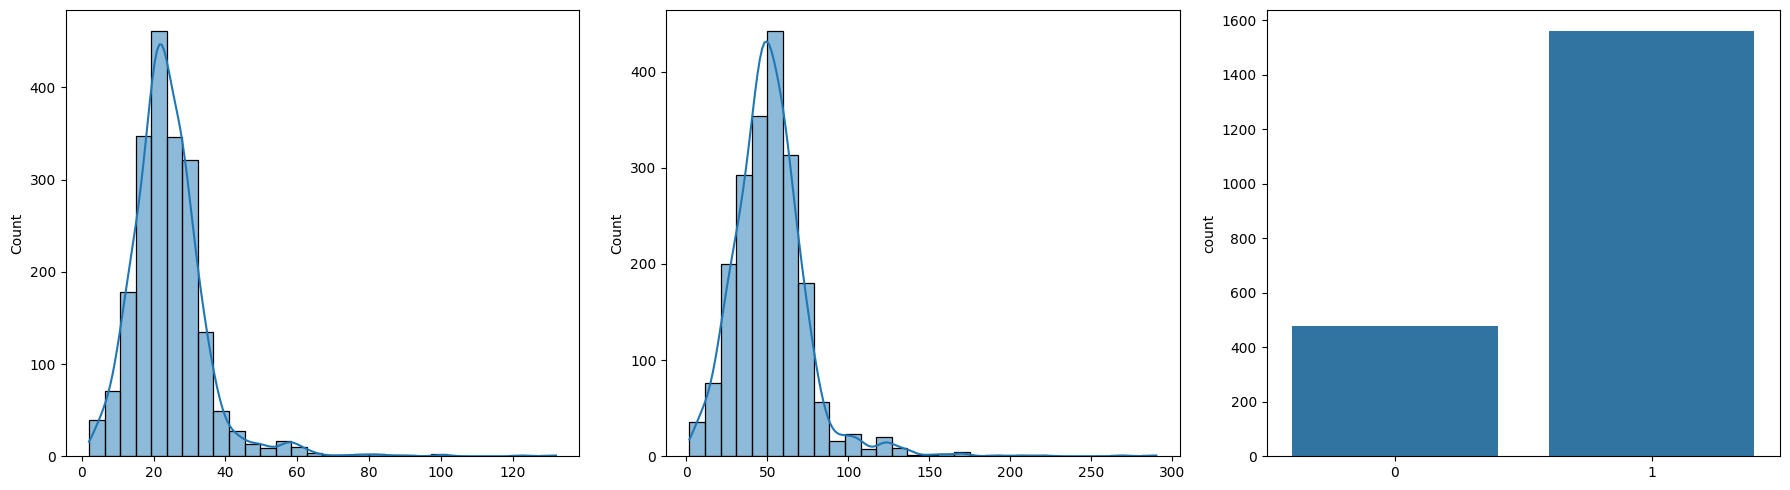

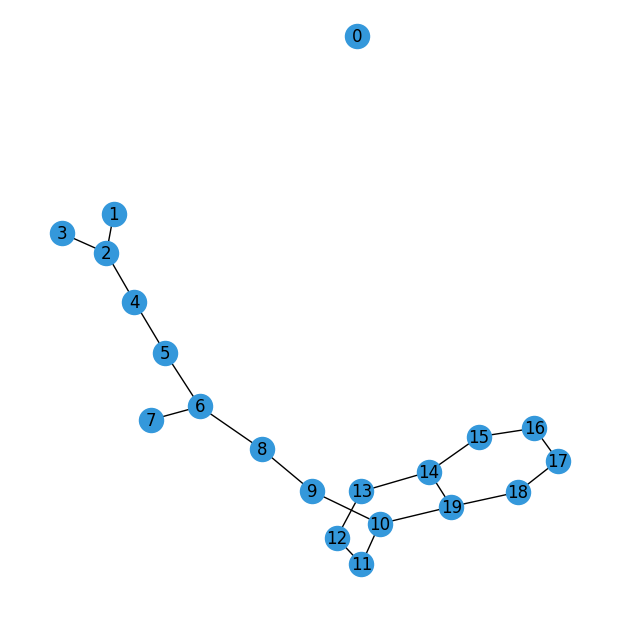

Sanity Check | Loss: 0.9037


In [1]:
import copy
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear
from torch_geometric.data import Data, Dataset
from torch_geometric.datasets import QM9, MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx


class Config:
    """Environment-based configuration."""

    PROJECT_NAME: str = "drug-discovery-ssl"
    DATASET_NAME: str = os.getenv("DATASET_NAME", "BBBP")
    DUMMY_RUN: bool = os.getenv("DUMMY_RUN", "False").lower() == "true"
    SEED: int = 42
    LABEL_RATE: float = 0.1
    BATCH_SIZE: int = 32

    @classmethod
    def __repr__(cls) -> str:
        return f"Config(dataset={cls.DATASET_NAME}, dummy={cls.DUMMY_RUN})"


torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)


def load_dataset(name: str, root: str = "./data") -> Dataset:
    if name.upper() == "QM9":
        return QM9(root=os.path.join(root, "QM9"))
    return MoleculeNet(root=os.path.join(root, "MoleculeNet"), name=name)


def get_subset(dataset: Dataset, subset_size: int = 1000) -> Dataset:
    if len(dataset) <= subset_size:
        return dataset
    return dataset[torch.randperm(len(dataset))[:subset_size]]


full_dataset = load_dataset(Config.DATASET_NAME)
dataset = get_subset(full_dataset, 2000) if Config.DUMMY_RUN else full_dataset


def analyze_distributions(dataset: Dataset) -> None:
    labels = [
        int(d.y.item()) for d in dataset if d.y is not None and not torch.isnan(d.y)
    ]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.histplot([d.num_nodes for d in dataset], bins=30, ax=axes[0], kde=True)
    sns.histplot([d.num_edges for d in dataset], bins=30, ax=axes[1], kde=True)
    sns.countplot(x=labels, ax=axes[2])
    plt.tight_layout()
    plt.show()


def visualize_molecule(data: Data) -> None:
    g = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(6, 6))
    nx.draw(g, node_size=300, node_color="#3498db", with_labels=True)
    plt.show()


analyze_distributions(dataset)
visualize_molecule(dataset[0])


def create_ssl_loaders(
    dataset: Dataset, n_lbl: int, batch: int
) -> tuple[DataLoader, DataLoader, DataLoader]:
    indices = torch.randperm(len(dataset))
    split = int(0.8 * len(dataset))

    loader_lbl = DataLoader(dataset[indices[:n_lbl]], batch_size=batch, shuffle=True)
    loader_unlbl = DataLoader(
        dataset[indices[n_lbl:split]], batch_size=batch, shuffle=True
    )
    loader_test = DataLoader(dataset[indices[split:]], batch_size=batch, shuffle=False)

    return loader_lbl, loader_unlbl, loader_test


lbl_loader, unlbl_loader, test_loader = create_ssl_loaders(
    dataset, 50, Config.BATCH_SIZE
)


class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, hidden: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = Linear(hidden, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor) -> Tensor:
        x = x.float()
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin(x)


def update_teacher(
    student: torch.nn.Module, teacher: torch.nn.Module, alpha: float
) -> None:
    for s_p, t_p in zip(student.parameters(), teacher.parameters()):
        t_p.data.mul_(alpha).add_(s_p.data, alpha=1.0 - alpha)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = GCN(dataset.num_features, 64, dataset.num_classes).to(device)
teacher = copy.deepcopy(student).to(device)

for param in teacher.parameters():
    param.requires_grad = False

batch = next(iter(lbl_loader)).to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=0.01)

# Verification step
loss = F.cross_entropy(
    student(batch.x, batch.edge_index, batch.batch), batch.y.squeeze().long()
)
loss.backward()
optimizer.step()
update_teacher(student, teacher, alpha=0.95)

print(f"Sanity Check | Loss: {loss.item():.4f}")